In [1]:
#!/usr/bin/env python
# coding: utf-8

import sys
# load standard python modules

import os
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib.backends.backend_pdf import PdfPages

# load torch modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# load custom modules required for jetCLR training
from modules.jet_augs import remove_jet_and_rescale_pT
from modules.transformer import Transformer
from modules.losses import contrastive_loss, align_loss, uniform_loss, contrastive_loss_num_den
from modules.perf_eval import get_perf_stats, linear_classifier_test, plot_losses
from modules.neural_net import create_and_run_nn


seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.cuda.empty_cache()


from numba import cuda 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
device = cuda.get_current_device()
device.reset()

torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "device: " + str( device ), flush=True)




device: cuda


# Load in the data + crop

In [2]:
path_to_save_dir = "/global/home/users/rrmastandrea/training_data/"

sig_samp_id = "CWoLa_n_sig_15900_n_bkg_0_n_nonzero_50_n_pad_0_n_jet_2/"
bkg_samp_id = "CWoLa_n_sig_0_n_bkg_15900_n_nonzero_50_n_pad_0_n_jet_2/"

TEST_dir = "STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/"

n_constits_max = 50
n_jets = 2

path_to_sig_data = path_to_save_dir+sig_samp_id
print(path_to_sig_data)
path_to_bkg_data = path_to_save_dir+bkg_samp_id
print(path_to_bkg_data)

path_to_STS = path_to_save_dir+TEST_dir
print(path_to_STS)


sig_data = np.load(path_to_sig_data+"data_train.npy")
sig_labels = np.load(path_to_sig_data+"labels_train.npy")
bkg_data = np.load(path_to_bkg_data+"data_train.npy")
bkg_labels = np.load(path_to_bkg_data+"labels_train.npy")


STS_data = np.load(path_to_STS+"data.npy")
STS_labels = np.load(path_to_STS+"labels.npy")

n = 26000

# Crop the data, rescale pt
cropped_sig_data = remove_jet_and_rescale_pT(sig_data, n_jets)[:n,:,:]
cropped_bkg_data = remove_jet_and_rescale_pT(bkg_data, n_jets)[:n,:,:]
sig_labels = sig_labels[:n]
bkg_labels = bkg_labels[:n]

cropped_STS_data = remove_jet_and_rescale_pT(STS_data, n_jets)

# print data dimensions
print( "Sig data shape: " + str( cropped_sig_data.shape ), flush=True)
print( "Sig labels shape: " + str( sig_labels.shape ), flush=True)
print( "Bkg data shape: " + str( cropped_bkg_data.shape ), flush=True)
print( "Sig data shape: " + str( bkg_labels.shape ), flush=True)

print( "STS data shape: " + str( cropped_STS_data.shape ), flush=True)
print( "STS labels shape: " + str( STS_labels.shape ), flush=True)

num_consts_tot = 100

cropped_STS_data = np.reshape(cropped_STS_data,(cropped_STS_data.shape[0],3*num_consts_tot))


/global/home/users/rrmastandrea/training_data/CWoLa_n_sig_15900_n_bkg_0_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data/CWoLa_n_sig_0_n_bkg_15900_n_nonzero_50_n_pad_0_n_jet_2/
/global/home/users/rrmastandrea/training_data/STANDARD_TEST_SET_n_sig_10k_n_bkg_10k_n_nonzero_50_n_pad_0_n_jet_2/
Sig data shape: (15900, 3, 100)
Sig labels shape: (15900,)
Bkg data shape: (15900, 3, 100)
Sig data shape: (15900,)
STS data shape: (20000, 3, 100)
STS labels shape: (20000,)


# Functions to generate mixed samples, then train-val-test splits

In [3]:
# Make mixed samples

def generate_mixed_sample(sig_set, bkg_set, f):
    
    """
    INPUTS
    f: signal fraction for sample 1
        -- by default, the signal fraction for sample 2 is 1 - f
    
    OUTPUTS
    M1_reps, M2_reps : shuffled array of [signal + background] samples
    """
    ((sig_M1, sig_M2),
     (bkg_M2, bkg_M1),) = [train_test_split(arr, test_size=(1-f)) for arr in [
                                                sig_set,
                                                bkg_set,]] 
    # concatenate the signal, background
    M1_reps = np.concatenate((sig_M1, bkg_M1))
    M2_reps = np.concatenate((sig_M2, bkg_M2))
    
    # shuffle
    M1_reps = shuffle(M1_reps)
    M2_reps = shuffle(M2_reps)
    
    return M1_reps, M2_reps

# Make the test - val - train splits

def generate_train_test_val(M1, M2, test_size = 0.0, val_size = 0.3):
    """
    INPUTS
    M1: np.array of data to be given the label 1
    M2: np.array of data to be given the label 0
    
    OUPUTS
    training, validation, and testing datasets + labels
    
    """
    """
    # split data into train-test
    ((M1_train, M1_test),
     (M2_train, M2_test),) = [train_test_split(arr, test_size=test_size) for arr in [
                                                M1,
                                               M2,]]

    """
    # split train data into train-val
    ((M1_train, M1_val),
     (M2_train, M2_val),) = [train_test_split(arr, test_size=val_size) for arr in [
                                                M1,
                                                M2,]]

    # prepare the datasets + labels
    data_train = np.concatenate((M1_train, M2_train))
    labels_train = np.concatenate([np.ones(M1_train.shape[0]),np.zeros(M2_train.shape[0])])
    data_train, labels_train = shuffle(data_train, labels_train)

    data_val = np.concatenate((M1_val, M2_val))
    labels_val = np.concatenate([np.ones(M1_val.shape[0]),np.zeros(M2_val.shape[0])])
    data_val, labels_val = shuffle(data_val, labels_val)
    
    """
    data_test = np.concatenate((M1_test, M2_test))
    labels_test = np.concatenate([np.ones(M1_test.shape[0]),np.zeros(M2_test.shape[0])])
    data_test, labels_test = shuffle(data_test, labels_test)
    """
    
    return data_train, labels_train, data_val, labels_val

    

# Testing the classifier (fully supervised)

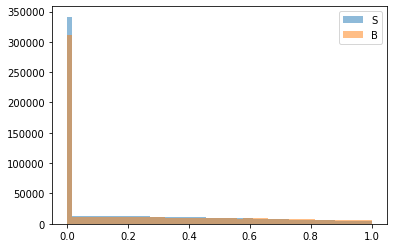

In [4]:
# Make the datasets


layer = 1

      
M1 = cropped_sig_data
M2 = cropped_bkg_data
bins = np.linspace(0,1,60)

    
S = np.reshape(M1[:,layer,:], (M1.shape[0]*M1.shape[2],1))
B = np.reshape(M2[:,layer,:], (M2.shape[0]*M2.shape[2],1))


plt.figure()
plt.hist(S, bins, label = "S", alpha = 0.5)
plt.hist(B, bins, label = "B", alpha = 0.5)
plt.legend()
plt.show()

In [5]:
data_train, labels_train, data_val, labels_val = generate_train_test_val(M1, M2)

# Define the NN parameters

full_sup_AUC = 0
full_sup_maxsic = 0
fixed_TPR = 0.5
full_sup_FPRatTPR = 0

data_train = np.reshape(data_train,(data_train.shape[0],3*num_consts_tot))
data_val = np.reshape(data_val,(data_val.shape[0],3*num_consts_tot))

# print data dimensions
print( "Train data shape: " + str( data_train.shape ), flush=True)
print( "Train labels shape: " + str( labels_train.shape ), flush=True)
print( "Val data shape: " + str( data_val.shape ), flush=True)
print( "Val labels shape: " + str( labels_val.shape ), flush=True)

input_shape = 3*num_consts_tot   
num_epochs = 1000
batch_size = 500
update_epochs = 10
lr = 0.0001

# Run the NN

performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                              data_train, labels_train, 
                              data_val, labels_val,
                              cropped_STS_data, STS_labels, 
                              verbose = True, early_stop = True, LRschedule = False)

# Plot the output losses   
plt.figure()
plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.yscale("log")
plt.legend()
plt.show()

plt.figure()
plt.plot(performance_stats["tpr"], 1.0/performance_stats["fpr"])
plt.yscale("log")
plt.xlabel("True Positive Rate")
plt.ylabel("1/(False Positive Rate)")
plt.show()

print("Accuracy of the network: %d %%" % (100.00 *performance_stats["acc"]))
print("ROC AUC:", performance_stats["auc"])

full_sup_AUC = performance_stats["auc"]

SIC = performance_stats["tpr"]/np.sqrt(performance_stats["fpr"])
finite_SIC = SIC[np.isfinite(SIC)]
full_sup_maxsic = np.max(finite_SIC)

dist_from_fixed_tpr = np.abs(performance_stats["tpr"] - fixed_TPR)
min_dist_ind = np.where(dist_from_fixed_tpr == np.min(dist_from_fixed_tpr))[0][0]
full_sup_FPRatTPR = np.sqrt(performance_stats["fpr"][min_dist_ind])

    
    


Train data shape: (22260, 300)
Train labels shape: (22260,)
Val data shape: (9540, 300)
Val labels shape: (9540,)
Starting training...


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

# Testing the classifier (CWoLa)

In [ ]:
# Define the NN parameters

input_shape = 3*num_consts_tot
num_epochs = 1000
batch_size = 500
update_epochs = 10
lr = 0.0001

visualize = True

f1_vals = []
ROC_AUC_vals = []
maxsic_vals = []
FPRatTPR_vals = []

for f1 in np.linspace(.05,.95,30):
    
    print("Starting CWoLa training run with f1 =", f1)
    f1_vals.append(f1)
    
    
    # make the datasets / mixed samples
    M1, M2 = generate_mixed_sample(cropped_sig_data, cropped_bkg_data, f1)
    data_train, labels_train, data_val, labels_val = generate_train_test_val(M1, M2)
    
    data_train = np.reshape(data_train,(data_train.shape[0],3*num_consts_tot))
    data_val = np.reshape(data_val,(data_val.shape[0],3*num_consts_tot))

    # print data dimensions
    print( "Train data shape: " + str( data_train.shape ), flush=True)
    print( "Train labels shape: " + str( labels_train.shape ), flush=True)
    print( "Val data shape: " + str( data_val.shape ), flush=True)
    print( "Val labels shape: " + str( labels_val.shape ), flush=True)

    # Run the NN

    # visualise the mixed samples

    if visualize:

        S = np.reshape(M1[:,0,:], (M1.shape[0]*M1.shape[2],1))
        B = np.reshape(M2[:,0,:], (M2.shape[0]*M2.shape[2],1))

        bins = np.linspace(0,1,60)
        plt.figure()
        plt.hist(S, bins, label = "S", alpha = 0.5)
        plt.hist(B, bins, label = "B", alpha = 0.5)
        plt.legend()
        plt.title("Rescaled pT")
        plt.show()

    performance_stats = create_and_run_nn(device, input_shape, num_epochs, batch_size, update_epochs, lr, 
                          data_train, labels_train, 
                          data_val, labels_val,
                          cropped_STS_data, STS_labels, 
                          verbose = True, early_stop = True, LRschedule = False)

    if visualize:
        # Plot the output losses   
        plt.figure()
        plt.plot(performance_stats["epochs"],performance_stats["losses"], label = "loss")
        plt.plot(performance_stats["val_epochs"],performance_stats["val_losses"], label = "val loss")
        plt.xlabel("Epochs")
        plt.ylabel("Losses")
        plt.yscale("log")
        plt.legend()
        plt.show()

        plt.figure()
        plt.plot(performance_stats["tpr"], 1.0/performance_stats["fpr"])
        plt.yscale("log")
        plt.xlabel("True Positive Rate")
        plt.ylabel("1/(False Positive Rate)")
        plt.show()

    print("Accuracy of the network: %d %%" % (100.00 *performance_stats["acc"]))
    print("ROC AUC:", performance_stats["auc"])

    ROC_AUC_vals.append(performance_stats["auc"])
    
    SIC = performance_stats["tpr"]/np.sqrt(performance_stats["fpr"])
    finite_SIC = SIC[np.isfinite(SIC)]
    maxsic_vals.append(np.max(finite_SIC))

    dist_from_fixed_tpr = np.abs(performance_stats["tpr"] - fixed_TPR)
    min_dist_ind = np.where(dist_from_fixed_tpr == np.min(dist_from_fixed_tpr))[0][0]
    FPRatTPR_vals.append(np.sqrt(performance_stats["fpr"][min_dist_ind]))
    
    print()




In [ ]:
pdf_name = "JetCLR_CWoLa_ConstRep.pdf"
pp = PdfPages(pdf_name)
    

fig = plt.figure()
plt.scatter(f1_vals, [max(x, 1.0-x) for x in ROC_AUC_vals], label = "CWoLa")
plt.scatter(f1_vals, np.full(len(f1_vals), full_sup_AUC), label = "Full. Sup.", color = "k")
plt.legend()
plt.xlabel("f1")
plt.ylabel("AUC")
plt.ylim(0.5, 0.89)
plt.title("Const. Rep")
plt.show()
pp.savefig(fig)

fig = plt.figure()
plt.scatter(f1_vals, maxsic_vals, label = "CWoLa")
plt.scatter(f1_vals, np.full(len(f1_vals), full_sup_maxsic), label = "Full. Sup.", color = "k")
plt.legend()
plt.xlabel("f1")
plt.ylabel("maxSIC")
plt.ylim(0.95, 2.7)
plt.title("Const. Rep")
plt.show()
pp.savefig(fig)

fig = plt.figure()
plt.scatter(f1_vals, FPRatTPR_vals, label = "CWoLa")
plt.scatter(f1_vals, np.full(len(f1_vals), full_sup_FPRatTPR), label = "Full. Sup.", color = "k")
plt.legend()
plt.xlabel("f1")
plt.ylabel("FPR @ TPR = 0.5")
plt.ylim(0.2, 0.75)
plt.title("Const. Rep")
plt.show()
pp.savefig(fig)


    
pp.savefig(fig)
pp.close()


